# Mechanistic modeling of $\delta O_{18}$ composition in Kauri tree rings

In [42]:
from IPython.display import Image

<dif style="font-size:125%">

This [IPython](www.ipython.org) notebook accompanies the paper:  
    
**Stable oxygen isotope signatures of early season wood in *agathis australis* (Kauri) tree-ring earlywood: Preliminary results and prospects for palaeoclimate reconstructions**

By *Andrew M. Lorrey, Tom H. Brookman, Michael N. Evans, Nicolas C. Fauchereau, Margaret Barbour, Cate Macinnis-Ng, Alison Criscitiello, Greg Eisheid, Anthony M. Fowler, Travis Horton and Daniel P. Schrag*

*Journal of Geophysical Research - Atmosphere*, to be submitted.

The code for this model originates from an Excel file provided by Dr. Margaret Barbour, and follows the BFRE04 model, augmented with a leaf energy balance model

Instructions regarding the installation of the necessary libraries and on how to run this notebook are provided in the **README.md** file, located in the main directory. 

All code and data is available on github at: 

[https://github.com/nicolasfauchereau/model_isotope](https://github.com/nicolasfauchereau/model_isotope)

see diagram below, which depicts a flow chart related to Figure 3 in the text. The calculations associated with each major part of the flow chart are found in Supplementary Workbook 1.

<img src='https://raw.githubusercontent.com/nicolasfauchereau/model_isotope/master/figures/Lorreyetal2015SF.jpg' width=800>

<hr size=5>

### The line below makes sure the graphics are displayed inline in the notebook 

In [61]:
%matplotlib inline

In [62]:
from IPython.html.widgets import interactive, interact, fixed
from IPython.html import widgets

### This import the required libraries (see instructions in the README.md file)

In [63]:
import os
from math import exp
from itertools import product
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import zscore, pearsonr

In [64]:
from statsmodels.formula.api import ols as OLS

In [65]:
from datetime import datetime

In [66]:
tstamp = datetime.utcnow().strftime("%Y%m%d%H%S"); print(tstamp)

201504150328


### Defines the path where to find the csv files 

In [67]:
dpath = '../excel'

### Defines the path where to save the figures

In [68]:
fpath = '../figures'

### Below is a small function to convert degrees Celsius to Kelvin 

In [69]:
def C2K(T):
    """
    conversion celsius to Kelvin
    """
    return T + 273.16

<a id='Step_1'></a>

## STEP 1: Define the parameter space of the model <hr size=5>

<dif style="font-size:125%">

**Each parameter entering the calculations of $\delta 18_{O}$ can be defined as :**  
> + ```np.linspace(min, max, steps)``` creates ```steps``` values between ```min``` (included) and ```max``` (not included)  
> + ```[value,]``` A real value (e.g. 0.015), brackets around and comma **are importants**  
> + ```[value1,value2,...]``` A list of specific real values to test 

Commented lines start with ```#``` (the keyboard shortcut ```<ctrl-/>``` (```<command-/>``` on mac) toggles commented lines)

A brief description of each parameter is provided below: 

+ **gs_l** is the stomatal conductance 
+ **leaf_width_l** is the leaf width, accepted values for New Zealand kauri is 0.015 m.
+ **d_source_H2O_l** is composition of source water, determined using OIPC
+ **fract_through_stomata_l** is the fractionation factor for diffusion through air (32 per mille; Cappa et al. 2003)
+ **fract_through_boundary_layer_l** is the fractionation factor for diffusion through the boundary layer (21 per mille; Cernusak et al. 2003)
+ **eff_length_l** is the length over which the Peclet effect is evident (m); typically this length is tortuous and is orders of magnitude greater than the actual distance between central vein and evaporating sites (following Barbour and Farquhar 2004)
+ **C_l** is the molar density of water (55.5 x 10^3 mol m-3)
+ **C_O_fract_l** is the fractionation factor between carbonyl oxygen and water (27 per mille) 
+ **Dcel_Dom_l** is Delta cellulose - Delta organic matter
+ **prop_exc_l** is the proportion of exchangeable oxygen in cellulose formed from simple carbohydrates
+ **prop_Xylem_l** is the proportion of unenriched (source) water in developing cell
+ **PAR_l** is the **P**hotosynthetic **A**ctive **R**adiation, in units of $\mu mol.m^{-2}.s^{-1}$


In [70]:
from collections import OrderedDict
dict_params = OrderedDict()
dict_params['gs'] = (0.13)  
dict_params['leaf_width'] = 0.015
dict_params['d_source_H2O'] = -4.3
dict_params['fract_through_stomata'] = 32.0
dict_params['fract_through_boundary_layer'] = 21.0
# **eff_length** is the effective length at a minimum is double the average distance for a 
# stomata to the central vein. For kauri, the avg distance is 0.0035m.  
# Thus, the minimum for this variable is about 0.0077m.  
# Untested theory however suggests at least 2 orders of magnitude for the avg distance, so 0.35m
# eff_length_l = [0.0077,]
# eff_length_l = np.linspace(0.0035,2,10, endpoint=True)
# eff_length_l = [0.045,] #! EFFECTIVE LENGTH IS NOW CALCULATED AS A FUNCTION OF E (transpiration) 
# following Song et al. 2013, sans pine data
dict_params['C'] = 5.55e4
#### Constants for calculations of $\Delta$ cellulose and $\Delta$ leaf
#dict_params['C_O_fract'] = (22.5,29.5)
dict_params['Dcel_Dom'] = 9.
dict_params['prop_exc'] = (0.15, 0.65)
dict_params['prop_Xylem'] = (0.85, 1.00)
#dict_params['PAR'] = (545)

### this is for the widget machinery

In [71]:
for k in dict_params.keys(): 
    if isinstance(dict_params[k], float): 
        dict_params[k] = fixed(dict_params[k])

### Reads the inputs (relative humidity, air temperature, pressure, windspeed) from the csv file

In [72]:
inputs = pd.read_csv(os.path.join(dpath,'inputs.csv'), index_col = 0)

In [73]:
inputs.head()

,Rh,Air T,Pressure,windspeed,PAR,MZ3 cont
Year,,,,,,
2009,84.40,14.27,1015.3,5.4,1135,36.000000
2008,79.80,14.63,1018.3,5.3,1080,-2.000000
2007,78.40,14.43,1017.1,4.9,1041,1.000000
2006,81.25,14.80,1018.7,5.4,1060,25.666667
2005,81.30,15.07,1016.2,4.9,1094,-3.333333


### Reads the ```observed``` values of $\delta 18_{0}$ 

In [74]:
obs = pd.read_csv(os.path.join(dpath,'observed_tree_rings.csv'), index_col=0)

In [75]:
obs.head()

,av,std
year,,
2009,-0.964275,-1.4173
2008,1.130145,-1.3576
2007,0.957118,-1.2979
2006,-1.459511,-1.2382
2005,-0.324430,-1.1785


### Multiply by the standard deviation and add the mean to get the $\delta 18_{O}$ values

In [76]:
obs['raw'] = (obs['av']*1.73) + 32.06

### define the main function to run the model and create the plots

In [77]:
# %load model.py
def run_model(df, obs, **kwargs):
    for key in kwargs.keys():
        exec(key + " = kwargs['" + key + "']")
    
    transpiration_cat = []

    res = []

    for index in xrange(len(df)): 

        ### ===========================================================================
        ### loops over the inputs 
        #rh, airtemp, pressure, windspeed, PAR = df.irow(index)
        rh, airtemp, pressure, windspeed, PAR, MZ3 = df.irow(index)

        ### ===========================================================================
        ### Energy balance calculations 

        r_times_b = 3.8 * (leaf_width**0.25)*(windspeed**(-0.5))

        #rb = 0.89 * r_times_b
        rb = 1.78 * r_times_b

        #gs = (1/(0.000442/windspeed) * ((1/(rh/100))-1) - rb)

        rs = 1. / gs

        gr = (4*0.98*(0.000000056703)*(C2K(airtemp)**3))/(29.2)

        rBH = 1./((1./r_times_b)+gr)

        Qtot = (PAR/4.6)*2

        Qabs = 0.5 * Qtot

        ### ===========================================================================
        ### Calculating $\epsilon$

        lesstemp = airtemp - 1.

        estemp = (6.13753 * exp(lesstemp * ((18.564 - (lesstemp/254.4)))/(lesstemp +255.57)))*100

        lesstemp_K = C2K(lesstemp)

        s = (((6.13753 * exp(airtemp * ((18.564 - (airtemp/254.4)))/(airtemp +255.57))))-estemp)\
        /(C2K(airtemp)-C2K(lesstemp))

        smbar = 6.13753*(((airtemp+255.7)*(18.564 - (2*airtemp/254.4)) - airtemp*(18.564 - \
                            (airtemp/254.4)))/((airtemp+255.57)**2))*(exp(airtemp*(18.564 - \
                                                        (airtemp/254.4))/(airtemp + 255.57)))

        epsilon = (smbar*44012)/(29.2*(pressure))

        ### ===========================================================================
        ### Calculating $\frac{EA}{EI}$

        ea = (rh / 100) * (6.13753 * exp(airtemp * ((18.564 - (airtemp/254.4)))/(airtemp +255.57)))

        es = (6.13753 * exp(airtemp * ((18.564 - (airtemp/254.4)))/(airtemp +255.57)))

        D = (((6.13753 * exp(airtemp * ((18.564 - (airtemp/254.4)))\
                             /(airtemp +255.57))))-ea)/pressure

        temp_diff = (rBH*((Qabs*(rs+rb))-(44012*D)))/(29.2*(rs+rb+(epsilon*rBH)))

        leaf_temp = airtemp + temp_diff

        ei = (6.13753 * exp(leaf_temp * ((18.564 - (leaf_temp/254.4)))\
                            /(leaf_temp +255.57)))

        leaf_temp_K = C2K(leaf_temp)

        ea_ei = ea / ei

        ### ===========================================================================
        ### Calculating transpiration

        transpiration = (epsilon * rBH * Qabs / 44012. + D) \
        / (rs + rb + epsilon * rBH)

        ### ===========================================================================
        ### calculates Effective Length (eff_length) as a function of transpiration
        #L =(2.36*10^-5)*E^-1.2
        eff_length = (4.93*10**(-5)) * pow(transpiration, -0.663)
        #eff_length = (2.36*10**(-5)) * pow(transpiration, -1.2)
        #eff_length = (-0.18) * (transpiration) + 0.021
        #eff_length = ((0.0429 * transpiration**6) - (1.1799 * transpiration**5) + (12.984 * transpiration**4) - (73.184 * transpiration**3) + (224 * transpiration**2) - (358.84 * transpiration) + 264.06)

#Song, X, Barbour, M.M., Farquhar, G.D., Vann, D.R., Helliker, B.R. 2013. Transpiration rate relates to within- and
#across species variations in effective path length in a leaf water model of oxygen isotope enrichment. Plant, Cell
#and Environment, 36, 1338-1351; note that the equation used represents the best fit through 4 of 6 species analysed.
        ### ===========================================================================
        ### Craig & Gordon parameters 

        #MZ3_cont = -0.0411*MZ3-0.2372
        #not implemented here, but for the future, to examine how accounting for source region affects variability of time series
        
        d_source_H2Oc = d_source_H2O
        
        d_water_vapour = (0.9916*d_source_H2Oc-10.465)
        #d_water_vapour = d_source_H2O + -1*(2.644-3.206*(1000/C2K(airtemp))+\
                                            #1.534*(1e6/(C2K(airtemp)*C2K(airtemp))))

        ek = ((fract_through_stomata*1/gs)+(fract_through_boundary_layer*rb))/((1/gs)+rb)

        e_star = 2.644-3.206*((1e3)/leaf_temp_K)+1.534*((10**6)/(leaf_temp_K**2))

        dv = ((d_water_vapour/1e3)*(1+(d_source_H2Oc/1e3))+(d_source_H2Oc/1e3))*1e3

        dv = ((d_water_vapour/1e3)*(1+(d_source_H2Oc/1e3))+(d_source_H2Oc/1e3))*1e3

        de = ek+e_star+((d_water_vapour-ek)*ea_ei)

        ### ===========================================================================
        ### Estimating the Peclet effect 

        D_Peclet = 0.000000119*(exp(-(637/(leaf_temp_K-137))))

        p_Peclet = (transpiration*eff_length)/(C*D_Peclet)

        DL = (de*(1-exp(-1*p_Peclet)))/p_Peclet

        dL = ((DL/1e3)*(1+(d_source_H2Oc/1e3))+(d_source_H2Oc/1e3))*1e3

        ### ===========================================================================
        ### Calculating $\Delta$ cellulose and $\Delta$ leaf

        C_O_fract = ((0.0084*(airtemp**2)) - (0.51*airtemp) + 33.172) 
        #from Sternberg L, Ellsworth PFV (2011) 
        #Divergent Biochemical Fractionation, Not Convergent Temperature, Explains Cellulose Oxygen Isotope Enrichment 
        #across Latitudes. PLoS ONE 6(11): e28040. doi:10.1371/journal.pone.0028040
        
        D_sucrose = (DL) + C_O_fract

        D_cellulose = ((DL)*(1-(prop_exc*prop_Xylem)))+C_O_fract # only place where prop_ex appears
        
        #D_cellulose = (DL*(1-(prop_exc*prop_Xylem)))+C_O_fract+MZ3_cont # only place where prop_ex appears

        D_leaf = D_cellulose - Dcel_Dom

        d_sucrose = ((D_sucrose/1e3)*(1+(d_source_H2Oc/1e3))+(d_source_H2Oc/1e3))*1e3

        d_leaf = ((D_leaf/1e3)*(1+(d_source_H2Oc/1e3))+(d_source_H2Oc/1000))*1e3

        ### ===========================================================================
        ### OUTPUT = $\Delta O_{18}$ in tree-rings cellulose

        OUTPUT = ((D_cellulose/1e3)*(1+(d_source_H2Oc/1e3))+(d_source_H2Oc/1e3))*1e3

        res.append(OUTPUT)
    
    res = np.array(res)
    res = pd.DataFrame(res, index=df.index)
    
    # calculates the RMSE
    RMSE = np.sqrt((obs['raw'].values - res.values)**2).mean()
    
    # calculates the correlation coefficient and the p-value
    R, P = pearsonr(obs['raw'].values.flatten(), res.values.flatten())
    
    ave = res.values.mean()
    
    variance = np.var(res.values)
    
    obs_ave = obs['raw'].values.mean()
    
    obs_variance = np.var(obs['raw'].values)
    
    
    #print(res)
    
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    ax = axes[0]
    #ax.plot(inputs.index, l, color='coral', lw=1.5, zorder=2)
    ax.plot(res.index, res.values, color='b', lw=3, label='simulation')
    ax.plot(obs.index, obs['raw'].values, color='k', lw=3, label='observations')
    ax.errorbar(obs.index, obs['raw'].values, yerr=obs['std'].values, fmt='o', color='k')
    ax.set_title('a) Raw data: RMSE = {:<4.2f}\nmod. ave: {:<4.2f}, mod. var: {:<4.2f}\nobs. ave: {:<4.2f}, obs. var: {:<4.2f}'.\
                 format(RMSE, ave, variance, obs_ave, obs_variance), fontsize=16)
    [x.set_fontsize(14) for x in ax.yaxis.get_ticklabels()]
    [x.set_fontsize(14) for x in ax.xaxis.get_ticklabels()]
    ax.legend(loc=0)
    ax.grid('on')
    ax.set_ylim(25, 37)
    
    ax = axes[1]
    ax.plot(res.index, zscore(res.values), color='b', lw=3, label='normalized simulation')
    ax.plot(obs.index, zscore(obs['raw'].values), color='k', lw=3, label='normalized observations')
    ax.errorbar(obs.index, zscore(obs['raw'].values), yerr=obs['std'].values, fmt='o', color='k')
    ax.set_title('b) norm. data, R={:+4.2f}, p={:4.2f}\n\n'.format(R, P), fontsize=16)
    [x.set_fontsize(14) for x in ax.yaxis.get_ticklabels()]
    [x.set_fontsize(14) for x in ax.xaxis.get_ticklabels()]
    ax.legend(loc=0)
    ax.grid('on')
    ax.set_ylim(-6, 6)
  
    plt.show()
    
    print(80*"-")
    for key in kwargs.keys():
        print("{}: {}".format(key, kwargs[key]))
    print(80*"-")

    

### Interact with the model

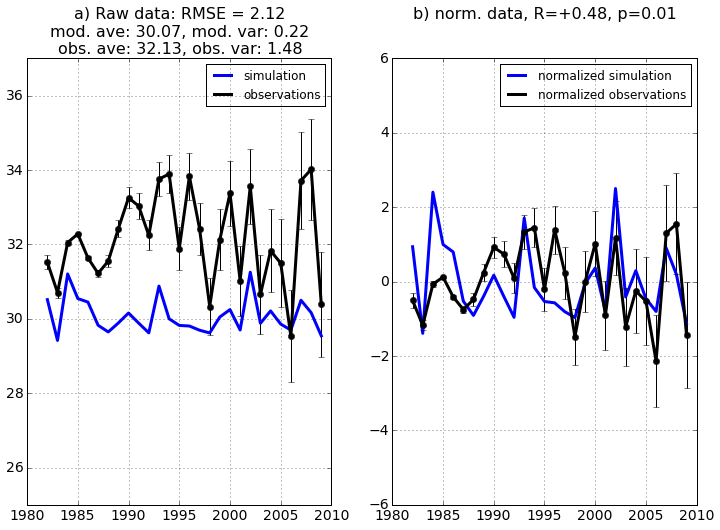

--------------------------------------------------------------------------------
C: 55500.0
gs: 0.13
fract_through_boundary_layer: 21.0
leaf_width: 0.015
d_source_H2O: -4.3
prop_exc: 0.4
fract_through_stomata: 32.0
Dcel_Dom: 9.0
prop_Xylem: 0.925
--------------------------------------------------------------------------------


<function __main__.run_model>

In [78]:
interact(run_model, df=fixed(inputs), obs=fixed(obs), **dict_params)

<a id='Step_3'></a>